# Data prepare

## surface

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gcsfs
import zarr
import xarray

# 设置滚动预报的周数
forecast_weeks = 6  # 预测未来6周

# 变量列表及其统计信息
variables = [
    'lsrr',               # Large-scale precipitation rate
    'crr',                # Convective precipitation rate
    'tciw',               # Specific cloud ice
    'tcc',                # Total cloud cover
    'tsrc',               # Top net long-wave radiation flux
    'u10',                # 10m u wind component
    'v10',                # 10m v wind component
    'd2m',                # 2m dewpoint temperature
    't2m',                # 2m temperature
    'surface_latent_heat_flux',  # Surface latent heat flux
    'surface_sensible_heat_flux',  # Surface sensible heat flux
    'sp',                 # Surface pressure
    'swvl',               # Volumetric soil water
    'msl',                # Sea-level pressure
    'siconc',             # Sea ice
    'sst'                 # Sea surface temperature
]

upper_air_vars = [
    'geopotential',
    'vertical_velocity',
    'u_component_of_wind',
    'v_component_of_wind',
    'fraction_of_cloud_cover',
    'temperature',
    'specific_humidity'
]

surface_var_names = [
    'large_scale_rain_rate',
    'convective_rain_rate',
    'total_column_cloud_ice_water',
    'total_cloud_cover',
    'top_net_solar_radiation_clear_sky',
    '10m_u_component_of_wind',
    '10m_v_component_of_wind',
    '2m_dewpoint_temperature',
    '2m_temperature',
    'surface_latent_heat_flux',
    'surface_sensible_heat_flux',
    'surface_pressure',
    'volumetric_soil_water_layer',
    'mean_sea_level_pressure',
    'sea_ice_cover',
    'sea_surface_temperature'
]

# 变量统计信息
ordered_var_stats = {
    'lsrr': {'mean': 1.10E-05, 'std': 2.55E-05},
    'crr': {'mean': 1.29E-05, 'std': 2.97E-05},
    'tciw': {'mean': 0.022627383, 'std': 0.023428712},
    'tcc': {'mean': 0.673692584, 'std': 0.235167906},
    'tsrc': {'mean': 856148, 'std': 534222.125},
    'u10': {'mean': -0.068418466, 'std': 4.427545547},
    'v10': {'mean': 0.197138891, 'std': 3.09530735},
    'd2m': {'mean': 274.2094421, 'std': 20.45770073},
    't2m': {'mean': 278.7841187, 'std': 21.03286934},
    'surface_latent_heat_flux': {'mean': -5410301.5, 'std': 5349063.5},
    'surface_sensible_heat_flux': {'mean': -971651.375, 'std': 2276764.75},
    'sp': {'mean': 96651.14063, 'std': 9569.695313},
    'swvl': {'mean': 0.34216917, 'std': 0.5484813},
    'msl': {'mean': 100972.3438, 'std': 1191.102417},
    'siconc': {'mean': 0.785884917, 'std': 0.914535105},
    'sst': {'mean': 189.7337189, 'std': 136.1803131},
    
    # 高空层变量（按新顺序排列）
    'geopotential': {
        '300': {'mean': 13763.50879, 'std': 1403.990112},
        '500': {'mean': 28954.94531, 'std': 2085.838867},
        '700': {'mean': 54156.85547, 'std': 3300.384277},
        '850': {'mean': 89503.79688, 'std': 5027.79541}
    },
    'vertical_velocity': {
        '300': {'mean': 0.011849277, 'std': 0.126232564},
        '500': {'mean': 0.002759292, 'std': 0.097579598},
        '700': {'mean': 0.000348145, 'std': 0.072489716},
        '850': {'mean': 0.000108061, 'std': 0.049831692}
    },
    'u_component_of_wind': {
        '300': {'mean': 1.374536991, 'std': 6.700420856},
        '500': {'mean': 3.290786982, 'std': 7.666454315},
        '700': {'mean': 6.491596222, 'std': 9.875613213},
        '850': {'mean': 11.66026878, 'std': 14.00845909}
    },
    'v_component_of_wind': {
        '300': {'mean': 0.146550566, 'std': 3.75399971},
        '500': {'mean': 0.022800878, 'std': 4.179731846},
        '700': {'mean': -0.025720235, 'std': 5.324173927},
        '850': {'mean': -0.027837994, 'std': 7.523460865}
    },
    'fraction_of_cloud_cover': {
        '300': {'mean': 0.152513072, 'std': 0.15887706},
        '500': {'mean': 0.106524825, 'std': 0.144112185},
        '700': {'mean': 0.105878539, 'std': 0.112193666},
        '850': {'mean': 0.108120449, 'std': 0.108371623}
    },
    'temperature': {
        '300': {'mean': 274.8048401, 'std': 15.28209305},
        '500': {'mean': 267.6254578, 'std': 14.55300999},
        '700': {'mean': 253.1627655, 'std': 12.77071381},
        '850': {'mean': 229.0860138, 'std': 10.5536499}
    },
    'specific_humidity': {
        '300': {'mean': 0.004610791, 'std': 0.003879665},
        '500': {'mean': 0.002473272, 'std': 0.002312181},
        '700': {'mean': 0.000875093, 'std': 0.000944978},
        '850': {'mean': 0.000130984, 'std': 0.000145811}
    }
}

demo_start_time = '2025-02-01'
demo_end_time = '2025-02-14'
data_inner_steps = 24

In [2]:

ds_surface = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None
)[['large_scale_rain_rate', 'convective_rain_rate', 'total_column_cloud_ice_water', 'total_cloud_cover', \
   'top_net_solar_radiation_clear_sky', '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'surface_latent_heat_flux', 'surface_sensible_heat_flux', 'surface_pressure', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',\
    'mean_sea_level_pressure', 'sea_ice_cover', 'sea_surface_temperature']]
surface_full_19_1day = ds_surface.sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))

In [3]:
surface_full_19_1day

<xarray.Dataset>
Dimensions:                            (time: 14, latitude: 721, longitude: 1440)
Coordinates:
  * latitude                           (latitude) float32 90.0 89.75 ... -90.0
  * longitude                          (longitude) float32 0.0 0.25 ... 359.8
  * time                               (time) datetime64[ns] 2025-02-01 ... 2...
Data variables: (12/19)
    large_scale_rain_rate              (time, latitude, longitude) float32 ...
    convective_rain_rate               (time, latitude, longitude) float32 ...
    total_column_cloud_ice_water       (time, latitude, longitude) float32 ...
    total_cloud_cover                  (time, latitude, longitude) float32 ...
    top_net_solar_radiation_clear_sky  (time, latitude, longitude) float32 ...
    10m_u_component_of_wind            (time, latitude, longitude) float32 ...
    ...                                 ...
    volumetric_soil_water_layer_2      (time, latitude, longitude) float32 ...
    volumetric_soil_water_layer_3      (time, latitude, longitude) float32 ...
    volumetric_soil_water_layer_4      (time, latitude, longitude) float32 ...
    mean_sea_level_pressure            (time, latitude, longitude) float32 ...
    sea_ice_cover                      (time, latitude, longitude) float32 ...
    sea_surface_temperature            (time, latitude, longitude) float32 ...
Attributes:
    valid_time_start:       1940-01-01
    last_updated:           2025-03-29 01:48:28.965870+00:00
    valid_time_stop:        2024-12-31
    valid_time_stop_era5t:  2025-03-23

In [4]:
surface_full_19_1day['volumetric_soil_water_layer'] = (
    surface_full_19_1day['volumetric_soil_water_layer_1'] + 
    surface_full_19_1day['volumetric_soil_water_layer_2'] + 
    surface_full_19_1day['volumetric_soil_water_layer_3'] + 
    surface_full_19_1day['volumetric_soil_water_layer_4']
)

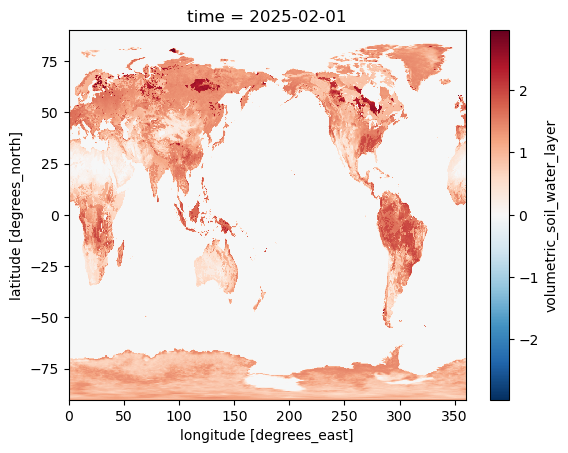

In [5]:
surface_full_19_1day['volumetric_soil_water_layer'].isel(time=0).plot()

In [6]:
import xarray as xr
import pandas as pd
# 更简单的方法：由于数据恰好是2周，直接分成前7天和后7天
# 获取第一周和第二周的数据
week1_data = surface_full_19_1day.isel(time=slice(0, 7))  # 前7天
week2_data = surface_full_19_1day.isel(time=slice(7, 14))  # 后7天

# 计算每周的平均值
week1_mean = week1_data.mean(dim='time')
week2_mean = week2_data.mean(dim='time')

# 合并为一个新的数据集，包含两周的平均值
weekly_means = xr.concat([week1_mean, week2_mean], 
                         dim=pd.Index([pd.to_datetime(week1_data.time.values[0]).strftime('%Y-%m-%d'), pd.to_datetime(week2_data.time.values[0]).strftime('%Y-%m-%d')], name='week'))

In [7]:
surface_input_weekly_means = weekly_means[['large_scale_rain_rate', 'convective_rain_rate', 'total_column_cloud_ice_water', 'total_cloud_cover', \
   'top_net_solar_radiation_clear_sky', '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'surface_latent_heat_flux', 'surface_sensible_heat_flux', 'surface_pressure', 'volumetric_soil_water_layer', \
    'mean_sea_level_pressure', 'sea_ice_cover', 'sea_surface_temperature']]

stacked_data = xr.concat([surface_input_weekly_means[var] for var in surface_input_weekly_means.data_vars], 
                         dim=xr.DataArray(list(surface_input_weekly_means.data_vars), dims='variable'))

In [8]:
var_mapping = {
    'large_scale_rain_rate': 'lsrr',
    'convective_rain_rate': 'crr',
    'total_column_cloud_ice_water': 'tciw',
    'total_cloud_cover': 'tcc',
    'top_net_solar_radiation_clear_sky': 'tsrc',
    '10m_u_component_of_wind': 'u10',
    '10m_v_component_of_wind': 'v10',
    '2m_dewpoint_temperature': 'd2m',
    '2m_temperature': 't2m',
    'surface_latent_heat_flux': 'surface_latent_heat_flux',
    'surface_sensible_heat_flux': 'surface_sensible_heat_flux',
    'surface_pressure': 'sp',
    'volumetric_soil_water_layer': 'swvl',
    'mean_sea_level_pressure': 'msl',
    'sea_ice_cover': 'siconc',
    'sea_surface_temperature': 'sst'
}

# 准备均值和标准差数组，形状为(16,1,1,1)，可以广播到(16,2,721,1440)
means = np.array([ordered_var_stats[var_mapping[var]]['mean'] for var in surface_input_weekly_means.data_vars])
stds = np.array([ordered_var_stats[var_mapping[var]]['std'] for var in surface_input_weekly_means.data_vars])

# 重塑形状用于广播
means = means.reshape(-1, 1, 1, 1)
stds = stds.reshape(-1, 1, 1, 1)

normalized_input_surface = (stacked_data.values - means) / stds

In [9]:
normalized_input_surface = np.nan_to_num(normalized_input_surface, nan=0.0)
normalized_input_surface.shape

(16, 2, 721, 1440)

## upper air

In [10]:
ds_upper_air = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None
)[['geopotential', 'vertical_velocity', 'u_component_of_wind', 'v_component_of_wind', 'fraction_of_cloud_cover', 'temperature', 'specific_humidity']]

# Select only pressure levels 300, 500, 700, 850 hPa
selected_levels = [300, 500, 700, 850]
ds_upper_air = ds_upper_air.sel(level=selected_levels)

upper_air_full_7_1day = ds_upper_air.sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))

In [11]:
import xarray as xr
import pandas as pd
# 更简单的方法：由于数据恰好是2周，直接分成前7天和后7天
# 获取第一周和第二周的数据
week1_data = upper_air_full_7_1day.isel(time=slice(0, 7))  # 前7天
week2_data = upper_air_full_7_1day.isel(time=slice(7, 14))  # 后7天

# 计算每周的平均值
week1_mean = week1_data.mean(dim='time')
week2_mean = week2_data.mean(dim='time')

# 合并为一个新的数据集，包含两周的平均值
upper_air_weekly_means = xr.concat([week1_mean, week2_mean], 
                         dim=pd.Index([pd.to_datetime(week1_data.time.values[0]).strftime('%Y-%m-%d'), pd.to_datetime(week2_data.time.values[0]).strftime('%Y-%m-%d')], name='week'))

In [12]:
upper_air_weekly_means

<xarray.Dataset>
Dimensions:                  (week: 2, level: 4, latitude: 721, longitude: 1440)
Coordinates:
  * latitude                 (latitude) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * level                    (level) int64 300 500 700 850
  * longitude                (longitude) float32 0.0 0.25 0.5 ... 359.5 359.8
  * week                     (week) object '2025-02-01' '2025-02-08'
Data variables:
    geopotential             (week, level, latitude, longitude) float32 8.363...
    vertical_velocity        (week, level, latitude, longitude) float32 0.053...
    u_component_of_wind      (week, level, latitude, longitude) float32 6.019...
    v_component_of_wind      (week, level, latitude, longitude) float32 26.65...
    fraction_of_cloud_cover  (week, level, latitude, longitude) float32 0.030...
    temperature              (week, level, latitude, longitude) float32 217.2...
    specific_humidity        (week, level, latitude, longitude) float32 2.22e...

In [13]:
# 按照指定的变量顺序
upper_air_vars = [
    'geopotential',
    'vertical_velocity',
    'u_component_of_wind',
    'v_component_of_wind',
    'fraction_of_cloud_cover',
    'temperature',
    'specific_humidity'
]

# 选择指定顺序的变量
upper_air_weekly_means = upper_air_weekly_means[upper_air_vars]

# 准备标准化
# 首先将数据转换为方便处理的格式
var_level_data = []
means = []
stds = []

# 对每个变量和每个气压层级，获取数据和对应的统计值
for var in upper_air_vars:
    for level in upper_air_weekly_means.level.values:
        level_str = str(level.item())
        
        # 获取该变量和层级的数据
        data = upper_air_weekly_means[var].sel(level=level)
        var_level_data.append(data)
        
        # 获取该变量和层级的均值和标准差
        means.append(ordered_var_stats[var][level_str]['mean'])
        stds.append(ordered_var_stats[var][level_str]['std'])

# 将数据合并到一个xarray数据集中
stacked_data_upper = xr.concat(var_level_data, 
                              dim=xr.DataArray([f"{var}_{level.item()}" for var in upper_air_vars 
                                               for level in upper_air_weekly_means.level.values], 
                                              dims='var_level'))

# 转换为numpy数组进行标准化
data_array = stacked_data_upper.values  # 形状为 (28, 2, 721, 1440) - 7变量×4层级×2周×格点数据

# 将均值和标准差转换为适合广播的形状
means_array = np.array(means).reshape(-1, 1, 1, 1)
stds_array = np.array(stds).reshape(-1, 1, 1, 1)

# 使用广播进行标准化
normalized_data = (data_array - means_array) / stds_array

In [14]:
normalized_input_upper_air = normalized_data.reshape(len(upper_air_vars), len(upper_air_weekly_means.level), 
                                              len(upper_air_weekly_means.week), 
                                              len(upper_air_weekly_means.latitude), 
                                              len(upper_air_weekly_means.longitude))


In [15]:
normalized_input_upper_air.shape

(7, 4, 2, 721, 1440)

# Model

In [16]:
import torch
from torch import nn
import numpy as np
from timm.models.layers import trunc_normal_, DropPath
import torch.nn.functional as F
import sys
sys.path.append('..')  # 添加上一级目录到路径
from canglong.earth_position import calculate_position_bias_indices
from canglong.shift_window import create_shifted_window_mask, partition_windows, reverse_partition
from canglong.embed import ImageToPatch2D, ImageToPatch3D, ImageToPatch4D
from canglong.recovery import RecoveryImage2D, RecoveryImage3D, RecoveryImage4D
from canglong.pad import calculate_padding_3d, calculate_padding_2d
from canglong.crop import center_crop_2d, center_crop_3d
input_constant = torch.load('../constant_masks/input_tensor.pt').cuda()

class UpSample(nn.Module):
    """
    Up-sampling operation.
    """

    def __init__(self, in_dim, out_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim * 4, bias=False)
        self.linear2 = nn.Linear(out_dim, out_dim, bias=False)
        self.norm = nn.LayerNorm(out_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

    def forward(self, x: torch.Tensor):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        x = self.linear1(x)
        x = x.reshape(B, in_pl, in_lat, in_lon, 2, 2, C // 2).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, in_pl, in_lat * 2, in_lon * 2, -1)

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        pad_h = in_lat * 2 - out_lat
        pad_w = in_lon * 2 - out_lon

        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        x = x[:, :out_pl, pad_top: 2 * in_lat - pad_bottom, pad_left: 2 * in_lon - pad_right, :]
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3], x.shape[4])
        x = self.norm(x)
        x = self.linear2(x)
        return x


class DownSample(nn.Module):
    """
    Down-sampling operation
    """

    def __init__(self, in_dim, input_resolution, output_resolution):
        super().__init__()
        self.linear = nn.Linear(in_dim * 4, in_dim * 2, bias=False)
        self.norm = nn.LayerNorm(4 * in_dim)
        self.input_resolution = input_resolution
        self.output_resolution = output_resolution

        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution

        assert in_pl == out_pl, "the dimension of pressure level shouldn't change"
        h_pad = out_lat * 2 - in_lat
        w_pad = out_lon * 2 - in_lon

        pad_top = h_pad // 2
        pad_bottom = h_pad - pad_top

        pad_left = w_pad // 2
        pad_right = w_pad - pad_left

        pad_front = pad_back = 0

        self.pad = nn.ZeroPad3d(
            (pad_left, pad_right, pad_top, pad_bottom, pad_front, pad_back)
        )

    def forward(self, x):
        B, N, C = x.shape
        in_pl, in_lat, in_lon = self.input_resolution
        out_pl, out_lat, out_lon = self.output_resolution
        x = x.reshape(B, in_pl, in_lat, in_lon, C)

        x = self.pad(x.permute(0, -1, 1, 2, 3)).permute(0, 2, 3, 4, 1)
        x = x.reshape(B, in_pl, out_lat, 2, out_lon, 2, C).permute(0, 1, 2, 4, 3, 5, 6)
        x = x.reshape(B, out_pl * out_lat * out_lon, 4 * C)

        x = self.norm(x)
        x = self.linear(x)
        return x


class EarthAttention3D(nn.Module):
    """
    3D window attention with earth position bias.
    """

    def __init__(self, dim, input_resolution, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0.,
                 proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.type_of_windows = (input_resolution[0] // window_size[0]) * (input_resolution[1] // window_size[1])

        self.earth_position_bias_table = nn.Parameter(
            torch.zeros((window_size[0] ** 2) * (window_size[1] ** 2) * (window_size[2] * 2 - 1),
                        self.type_of_windows, num_heads)
        )

        earth_position_index = calculate_position_bias_indices(window_size)
        self.register_buffer("earth_position_index", earth_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.earth_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor, mask=None):
        B_, nW_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, nW_, N, 3, self.num_heads, C // self.num_heads).permute(3, 0, 4, 1, 2, 5)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        earth_position_bias = self.earth_position_bias_table[self.earth_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.window_size[0] * self.window_size[1] * self.window_size[2],
            self.type_of_windows, -1
        )
        earth_position_bias = earth_position_bias.permute(
            3, 2, 0, 1).contiguous()
        attn = attn + earth_position_bias.unsqueeze(0)

        if mask is not None:
            nLon = mask.shape[0]
            attn = attn.view(B_ // nLon, nLon, self.num_heads, nW_, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, nW_, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).permute(0, 2, 3, 1, 4).reshape(B_, nW_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class EarthSpecificBlock(nn.Module):
    """
    3D Transformer Block
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=None, shift_size=None, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0., act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        window_size = (2, 6, 12) if window_size is None else window_size
        shift_size = (1, 3, 6) if shift_size is None else shift_size
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        padding = calculate_padding_3d(input_resolution, window_size)
        self.pad = nn.ZeroPad3d(padding)

        pad_resolution = list(input_resolution)
        pad_resolution[0] += (padding[-1] + padding[-2])
        pad_resolution[1] += (padding[2] + padding[3])
        pad_resolution[2] += (padding[0] + padding[1])

        self.attn = EarthAttention3D(
            dim=dim, input_resolution=pad_resolution, window_size=window_size, num_heads=num_heads, qkv_bias=qkv_bias,
            qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        shift_pl, shift_lat, shift_lon = self.shift_size
        self.roll = shift_pl and shift_lon and shift_lat

        if self.roll:
            attn_mask = create_shifted_window_mask(pad_resolution, window_size, shift_size)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x: torch.Tensor):
        Pl, Lat, Lon = self.input_resolution
        B, L, C = x.shape
        assert L == Pl * Lat * Lon, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, Pl, Lat, Lon, C)

        x = self.pad(x.permute(0, 4, 1, 2, 3)).permute(0, 2, 3, 4, 1)

        _, Pl_pad, Lat_pad, Lon_pad, _ = x.shape

        shift_pl, shift_lat, shift_lon = self.shift_size
        if self.roll:
            shifted_x = torch.roll(x, shifts=(-shift_pl, -shift_lat, -shift_lon), dims=(1, 2, 3))
            x_windows = partition_windows(shifted_x, self.window_size)
        else:
            shifted_x = x
            x_windows = partition_windows(shifted_x, self.window_size)

        win_pl, win_lat, win_lon = self.window_size
        x_windows = x_windows.view(x_windows.shape[0], x_windows.shape[1], win_pl * win_lat * win_lon, C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = attn_windows.view(attn_windows.shape[0], attn_windows.shape[1], win_pl, win_lat, win_lon, C)

        if self.roll:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = torch.roll(shifted_x, shifts=(shift_pl, shift_lat, shift_lon), dims=(1, 2, 3))
        else:
            shifted_x = reverse_partition(attn_windows, self.window_size, Pl_pad, Lat_pad, Lon_pad)
            x = shifted_x

        x = center_crop_3d(x.permute(0, 4, 1, 2, 3), self.input_resolution).permute(0, 2, 3, 4, 1)

        x = x.reshape(B, Pl * Lat * Lon, C)
        x = shortcut + self.drop_path(x)

        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x



class BasicLayer(nn.Module):
    """A basic 3D Transformer layer for one stage"""

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        self.blocks = nn.ModuleList([
            EarthSpecificBlock(dim=dim, input_resolution=input_resolution, num_heads=num_heads, window_size=window_size,
                               shift_size=(0, 0, 0) if i % 2 == 0 else None, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                               qk_scale=qk_scale, drop=drop, attn_drop=attn_drop,
                               drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                               norm_layer=norm_layer)
            for i in range(depth)
        ])

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        return x




class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
import torch
import torch.nn as nn
from canglong.helper import ResidualBlock, NonLocalBlock, DownSampleBlock, UpSampleBlock, GroupNorm, Swish

class Encoder(nn.Module):
    def __init__(self, image_channels, latent_dim):
        super(Encoder, self).__init__()
        channels = [64, 64, 64, 128, 128]
        attn_resolutions = [2]
        num_res_blocks = 1
        resolution = 256

        # 初始卷积层
        self.conv_in = nn.Conv3d(image_channels, channels[0], kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        
        # 第一层（含残差块和注意力模块）
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks, resolution, attn_resolutions)
        
        # 下采样与第二层
        self.downsample1 = DownSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks, resolution // 2, attn_resolutions)

        # Further downsampling and third layer
        self.downsample2 = DownSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks, resolution // 4, attn_resolutions)

        # 中间层的残差块和注意力模块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 输出层的归一化、激活和最终卷积层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.Conv3d(channels[3], latent_dim, kernel_size=3, stride=1, padding=(1,2,1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks, resolution, attn_resolutions):
        layers = []
        for _ in range(num_res_blocks):
            layers.append(ResidualBlock(in_channels, out_channels))
            in_channels = out_channels
            if resolution in attn_resolutions:
                layers.append(NonLocalBlock(in_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层，并存储跳跃连接
        x = self.layer1(x)
        skip = x  # 保存第一层输出，用于后续跳跃连接

        # 下采样，进入第二层
        x = self.downsample1(x)
        x = self.layer2(x)

        # Further downsample and third layer
        x = self.downsample2(x)
        x = self.layer3(x)

        # 中间层的残差块和注意力模块
        x = self.mid_block1(x)
        #x = self.mid_attn(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)
        x = self.conv_out(x)[:, :, :, :181, :360]
        
        return x
    
class Decoder(nn.Module):
    def __init__(self, image_channels=14, latent_dim=64):
        super(Decoder, self).__init__()
        channels = [128, 128, 64, 64]  # Decoder 的通道配置
        num_res_blocks = 1  # 与 Encoder 对齐

        # 初始卷积层
        self.conv_in = nn.Conv3d(latent_dim, channels[0], kernel_size=3, stride=1, padding=1)
        
        # 第一层残差块
        self.layer1 = self._make_layer(channels[0], channels[1], num_res_blocks)
        
        # 上采样和第二层残差块
        self.upsample1 = UpSampleBlock(channels[1])
        self.layer2 = self._make_layer(channels[1], channels[2], num_res_blocks)

        self.upsample2 = UpSampleBlock(channels[2])
        self.layer3 = self._make_layer(channels[2], channels[3], num_res_blocks)
        
        # 中间层的残差块
        self.mid_block1 = ResidualBlock(channels[3], channels[3])
        self.mid_block2 = ResidualBlock(channels[3], channels[3])
        
        # 最终输出层
        self.norm_out = GroupNorm(channels[3])
        self.act_out = Swish()
        self.conv_out = nn.ConvTranspose3d(channels[3], image_channels, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))

    def _make_layer(self, in_channels, out_channels, num_res_blocks):
        # 创建指定数量的残差块
        layers = [ResidualBlock(in_channels, out_channels) for _ in range(num_res_blocks)]
        return nn.Sequential(*layers)

    def forward(self, x):
        # 初始卷积
        x = self.conv_in(x)

        # 第一层残差块
        x = self.layer1(x)

        # 上采样和第二层残差块
        x = self.upsample1(x)  # 上采样后通道数保持不变

        x = self.layer2(x)     # 确保输入与 layer2 的期望通道数匹配

        x = self.upsample2(x)  # 上采样后通道数保持不变

        x = self.layer3(x)     # 确保输入与 layer2 的期望通道数匹配
        
        # 中间层的残差块
        x = self.mid_block1(x)
        x = self.mid_block2(x)
        
        # 最终的归一化、激活和卷积输出层
        x = self.norm_out(x)
        x = self.act_out(x)

        x = self.conv_out(x)[:, :, :, :721, :1440]
        
        return x


class Canglong(nn.Module):
    """
    CAS Canglong PyTorch impl of: `CAS-Canglong: A skillful 3D Transformer model for sub-seasonal to seasonal global sea surface temperature prediction`
    """

    def __init__(self, embed_dim=96, num_heads=(8, 16, 16, 8), window_size=(2, 6, 12)):
        super().__init__()
        drop_path = np.linspace(0, 0.2, 8).tolist()
        self.patchembed2d = ImageToPatch2D(
            img_dims=(721, 1440),
            patch_dims=(4, 4), # 8, 8
            in_channels=4,
            out_channels=embed_dim,
        )
        self.patchembed3d = ImageToPatch3D(
            img_dims=(14, 721, 1440),
            patch_dims=(1, 4, 4),
            in_channels=14,
            out_channels=embed_dim
        )
        self.patchembed4d = ImageToPatch4D(
            img_dims=(7, 4, 721, 1440),
            patch_dims=(4, 2, 4, 4),
            in_channels=7,
            out_channels=embed_dim
        )
        self.encoder3d = Encoder(image_channels=16, latent_dim=96)

        self.layer1 = BasicLayer(
            dim=embed_dim,
            input_resolution=(4, 181, 360),
            depth=2,
            num_heads=num_heads[0],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.downsample = DownSample(in_dim=embed_dim, input_resolution=(4, 181, 360), output_resolution=(4, 91, 180))
        self.layer2 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(4, 91, 180),
            depth=6,
            num_heads=num_heads[1],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.layer3 = BasicLayer(
            dim=embed_dim * 2,
            input_resolution=(4, 91, 180),
            depth=6,
            num_heads=num_heads[2],
            window_size=window_size,
            drop_path=drop_path[2:]
        )
        self.upsample = UpSample(embed_dim * 2, embed_dim, (4, 91, 180), (4, 181, 360))
        self.layer4 = BasicLayer(
            dim=embed_dim,
            input_resolution=(4, 181, 360),
            depth=2,
            num_heads=num_heads[3],
            window_size=window_size,
            drop_path=drop_path[:2]
        )
        self.patchrecovery2d = RecoveryImage2D((721, 1440), (4, 4), 2 * embed_dim, 4) #8, 8
        self.decoder3d = Decoder(image_channels=16, latent_dim=2 * 96)
        self.patchrecovery3d = RecoveryImage3D(image_size=(16, 721, 1440), 
                                               patch_size=(1, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=16) #2, 8, 8
        self.patchrecovery4d = RecoveryImage4D(image_size=(7, 4, 721, 1440), 
                                               patch_size=(4, 2, 4, 4), 
                                               input_channels=2 * embed_dim, 
                                               output_channels=7)
        self.conv_constant = nn.Conv2d(in_channels=4, out_channels=96, kernel_size=5, stride=4, padding=2)
        self.input_constant = input_constant


    def forward(self, surface, upper_air):
        
        
        constant = self.conv_constant(self.input_constant)
        surface = self.encoder3d(surface)

        upper_air = self.patchembed4d(upper_air)
        

        x = torch.concat([upper_air.squeeze(3), constant.unsqueeze(2), surface], dim=2)

        B, C, Pl, Lat, Lon = x.shape

        x = x.reshape(B, C, -1).transpose(1, 2)
        
        x = self.layer1(x)

        skip = x

        x = self.downsample(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.upsample(x)
        x = self.layer4(x)

        output = torch.concat([x, skip], dim=-1)
        output = output.transpose(1, 2).reshape(B, -1, Pl, Lat, Lon)

        output_surface = output[:, :, 2:, :, :]
        output_upper_air = output[:, :, 0, :, :]

        #output_surface = self.patchrecovery3d(output_surface)
        output_surface = self.decoder3d(output_surface)

        output_upper_air = self.patchrecovery4d(output_upper_air.unsqueeze(2).unsqueeze(3))

        return output_surface, output_upper_air


d:\miniconda\envs\torch\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [17]:
import torch
import numpy as np

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 假设已经有标准化后的输入数据
# normalized_input_surface: (16, 2, 721, 1440) - [变量, 周数, 纬度, 经度]
# normalized_input_upper_air: (7, 4, 2, 721, 1440) - [变量, 层级, 周数, 纬度, 经度]

# 转换为PyTorch张量
input_surface_tensor = torch.tensor(normalized_input_surface, dtype=torch.float32).unsqueeze(0)  # 添加批次维度
input_upper_air_tensor = torch.tensor(normalized_input_upper_air, dtype=torch.float32).unsqueeze(0)  # 添加批次维度

print(f"地表输入数据形状: {input_surface_tensor.shape}")  # 应为 [1, 16, 2, 721, 1440]
print(f"高空输入数据形状: {input_upper_air_tensor.shape}")  # 应为 [1, 7, 4, 2, 721, 1440]

# 加载模型
model_path = 'I:/model/model_epoch_500.pt'  # 使用最佳模型
print(f"正在从 {model_path} 加载模型...")
model = torch.load(model_path)
model.to(device)
model.eval()
print("模型加载成功")

# 设置预测的周数
forecast_weeks = 6

# 将数据移动到设备
current_input_surface = input_surface_tensor.to(device)
current_input_upper_air = input_upper_air_tensor.to(device)

# 存储滚动预报的结果
all_surface_predictions = []
all_upper_air_predictions = []

print(f"开始 {forecast_weeks} 周滚动预报...")

with torch.no_grad():
    # 滚动预报指定周数
    for week in range(forecast_weeks):
        # 前向传播
        output_surface, output_upper_air = model(current_input_surface, current_input_upper_air)
        
        # 存储当前周的预测结果
        all_surface_predictions.append(output_surface[:, :, 0:1, :, :])  # 只取第一个时间步
        all_upper_air_predictions.append(output_upper_air[:, :, :, 0:1, :, :])  # 只取第一个时间步
        
        print(f"完成第 {week+1} 周预测")
        
        if week < forecast_weeks - 1:  # 如果不是最后一周，准备下一周的输入
            # 更新输入：使用上一个时间步和新预测的时间步
            new_input_surface = torch.cat([
                current_input_surface[:, :, 1:2, :, :],  # 取当前输入的第二个时间步
                output_surface[:, :, 0:1, :, :]  # 取当前预测的第一个时间步
            ], dim=2)
            
            new_input_upper_air = torch.cat([
                current_input_upper_air[:, :, :, 1:2, :, :],  # 取当前输入的第二个时间步
                output_upper_air[:, :, :, 0:1, :, :]  # 取当前预测的第一个时间步
            ], dim=3)
            
            current_input_surface = new_input_surface
            current_input_upper_air = new_input_upper_air

# 合并所有周的预测结果
all_weeks_surface_predictions = torch.cat(all_surface_predictions, dim=2)  # [1, 16, forecast_weeks, 721, 1440]
all_weeks_upper_air_predictions = torch.cat(all_upper_air_predictions, dim=3)  # [1, 7, 4, forecast_weeks, 721, 1440]

print(f"滚动预报完成。")
print(f"所有周的地表预测形状: {all_weeks_surface_predictions.shape}")
print(f"所有周的高空预测形状: {all_weeks_upper_air_predictions.shape}")

# 将预测结果移回CPU并转换为numpy数组
surface_predictions_np = all_weeks_surface_predictions.cpu().numpy()
upper_air_predictions_np = all_weeks_upper_air_predictions.cpu().numpy()



print("可以使用denormalize_surface和denormalize_upper_air函数反标准化预测结果")
print("完成推理过程")

# 保存预测结果（可选）
# np.save('surface_predictions.npy', surface_predictions_np)
# np.save('upper_air_predictions.npy', upper_air_predictions_np)

使用设备: cuda
地表输入数据形状: torch.Size([1, 16, 2, 721, 1440])
高空输入数据形状: torch.Size([1, 7, 4, 2, 721, 1440])
正在从 I:/model/model_epoch_500.pt 加载模型...
模型加载成功
开始 6 周滚动预报...
完成第 1 周预测
完成第 2 周预测
完成第 3 周预测
完成第 4 周预测
完成第 5 周预测
完成第 6 周预测
滚动预报完成。
所有周的地表预测形状: torch.Size([1, 16, 6, 721, 1440])
所有周的高空预测形状: torch.Size([1, 7, 4, 6, 721, 1440])
可以使用denormalize_surface和denormalize_upper_air函数反标准化预测结果
完成推理过程


In [18]:
# 准备地表数据的均值和标准差数组，形状为(16,1,1,1)
surface_means = np.array([ordered_var_stats[var_mapping[var]]['mean'] for var in surface_var_names])
surface_stds = np.array([ordered_var_stats[var_mapping[var]]['std'] for var in surface_var_names])

# 重塑形状用于广播 - 注意增加了一个维度用于周数
surface_means = surface_means.reshape(-1, 1, 1, 1)
surface_stds = surface_stds.reshape(-1, 1, 1, 1)

# 使用广播一次性反标准化所有地表数据
denormalized_surface = surface_predictions_np * surface_stds + surface_means

In [19]:
denormalized_surface.shape

(1, 16, 6, 721, 1440)

In [20]:
import numpy as np
import xarray as xr
from datetime import datetime, timedelta

def data_to_xarray(denormalized_surface, demo_start_time='2025-02-01', demo_end_time='2025-02-14', forecast_weeks=6):
    """
    将反标准化的地表数据转换为xarray数据集，并计算预测时间点
    
    参数:
        denormalized_surface: 形状为(16, forecast_weeks, 721, 1440)的反标准化地表数据
        demo_start_time: 演示起始时间，格式为'YYYY-MM-DD'
        demo_end_time: 演示结束时间，格式为'YYYY-MM-DD'
        forecast_weeks: 预测的周数
    
    返回:
        surface_ds: 地表数据xarray数据集
    """
    # 定义变量名称
    surface_var_names = [
        'large_scale_rain_rate',
        'convective_rain_rate',
        'total_column_cloud_ice_water',
        'total_cloud_cover',
        'top_net_solar_radiation_clear_sky',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        '2m_dewpoint_temperature',
        '2m_temperature',
        'surface_latent_heat_flux',
        'surface_sensible_heat_flux',
        'surface_pressure',
        'volumetric_soil_water_layer',
        'mean_sea_level_pressure',
        'sea_ice_cover',
        'sea_surface_temperature'
    ]
    
    # 解析起始和结束时间
    start_date = datetime.strptime(demo_start_time, '%Y-%m-%d')
    end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
    
    # 计算预测时间点
    # 假设end_date是第二周的结束日期，我们从第三周开始预测
    forecast_start_date = end_date + timedelta(days=1)  # 从结束日期的下一天开始预测
    
    # 计算每个预测周的日期（取每周的最后一天）
    forecast_dates = []
    for i in range(forecast_weeks):
        # 每周结束日期 = 预测开始日期 + (i+1)*7 - 1 天
        week_end_date = forecast_start_date + timedelta(days=(i+1)*7-1)
        forecast_dates.append(week_end_date)
    
    # 创建坐标
    lat = np.linspace(90, -90, 721)
    lon = np.linspace(0, 359.75, 1440)
    
    # 创建地表数据的xarray数据集
    surface_ds = xr.Dataset(coords={
        'variable': surface_var_names,
        'time': forecast_dates,
        'latitude': lat,
        'longitude': lon
    })
    
    # 使用DataArray存储所有数据
    surface_data_array = xr.DataArray(
        denormalized_surface,
        dims=['variable', 'time', 'latitude', 'longitude'],
        coords={
            'variable': surface_var_names, 
            'time': forecast_dates, 
            'latitude': lat, 
            'longitude': lon
        }
    )
    
    # 将DataArray添加到Dataset中
    surface_ds['data'] = surface_data_array
    
    # 为每个变量创建单独的数据变量
    for i, var_name in enumerate(surface_var_names):
        surface_ds[var_name] = surface_data_array.sel(variable=var_name)
    
    # 计算总降水率并添加到数据集
    surface_ds['total_precipitation'] = surface_ds['large_scale_rain_rate'] + surface_ds['convective_rain_rate']
    
    # 添加预测周信息作为属性
    surface_ds.attrs['forecast_start_date'] = forecast_start_date.strftime('%Y-%m-%d')
    surface_ds.attrs['forecast_end_date'] = forecast_dates[-1].strftime('%Y-%m-%d')
    surface_ds.attrs['prediction_type'] = f"{forecast_weeks}-Week Forecast"
    surface_ds.attrs['input_data_period'] = f"{demo_start_time} to {demo_end_time}"
    
    return surface_ds

# 使用示例

# 假设我们已经有了反标准化的数据
demo_start_time = '2025-02-01'
demo_end_time = '2025-02-14'
forecast_weeks = 6

# 转换为xarray数据集
surface_ds = data_to_xarray(
    denormalized_surface[0], 
    demo_start_time=demo_start_time,
    demo_end_time=demo_end_time,
    forecast_weeks=forecast_weeks
)


print("预测时间范围:", surface_ds.attrs['forecast_start_date'], "至", surface_ds.attrs['forecast_end_date'])


预测时间范围: 2025-02-15 至 2025-03-28


In [21]:
surface_ds

<xarray.Dataset>
Dimensions:                            (variable: 16, time: 6, latitude: 721,
                                        longitude: 1440)
Coordinates:
  * variable                           (variable) <U33 'large_scale_rain_rate...
  * time                               (time) datetime64[ns] 2025-02-21 ... 2...
  * latitude                           (latitude) float64 90.0 89.75 ... -90.0
  * longitude                          (longitude) float64 0.0 0.25 ... 359.8
Data variables: (12/18)
    data                               (variable, time, latitude, longitude) float64 ...
    large_scale_rain_rate              (time, latitude, longitude) float64 -2...
    convective_rain_rate               (time, latitude, longitude) float64 -2...
    total_column_cloud_ice_water       (time, latitude, longitude) float64 0....
    total_cloud_cover                  (time, latitude, longitude) float64 0....
    top_net_solar_radiation_clear_sky  (time, latitude, longitude) float64 4....
    ...                                 ...
    surface_pressure                   (time, latitude, longitude) float64 9....
    volumetric_soil_water_layer        (time, latitude, longitude) float64 -0...
    mean_sea_level_pressure            (time, latitude, longitude) float64 1....
    sea_ice_cover                      (time, latitude, longitude) float64 0....
    sea_surface_temperature            (time, latitude, longitude) float64 27...
    total_precipitation                (time, latitude, longitude) float64 -2...
Attributes:
    forecast_start_date:  2025-02-15
    forecast_end_date:    2025-03-28
    prediction_type:      6-Week Forecast
    input_data_period:    2025-02-01 to 2025-02-14

In [22]:
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 定义时间范围
demo_start_time = '2025-02-01'
demo_end_time = '2025-02-14'
forecast_weeks = 6

# 计算预测时间点
end_date = datetime.strptime(demo_end_time, '%Y-%m-%d')
forecast_start_date = end_date + timedelta(days=1)  # 从结束日期的下一天开始预测

# 计算每个预测周的结束日期
forecast_dates = []
for i in range(forecast_weeks):
    # 每周结束日期 = 预测开始日期 + (i+1)*7 - 1 天
    week_end_date = forecast_start_date + timedelta(days=(i+1)*7-1)
    forecast_dates.append(week_end_date)

# 计算预测期间的ERA5数据时间范围
validation_start_date = forecast_start_date.strftime('%Y-%m-%d')
validation_end_date = forecast_dates[-1].strftime('%Y-%m-%d')

print(f"预测开始日期: {validation_start_date}")
print(f"预测结束日期: {validation_end_date}")

# 下载ERA5预测期间的真实数据
print(f"正在下载ERA5数据，从 {validation_start_date} 到 {validation_end_date}")

# 下载地表数据
ds_surface = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None
)[['large_scale_rain_rate', 'convective_rain_rate', 'total_column_cloud_ice_water', 'total_cloud_cover',
   'top_net_solar_radiation_clear_sky', '10m_u_component_of_wind', '10m_v_component_of_wind', 
   '2m_dewpoint_temperature', '2m_temperature', 'surface_latent_heat_flux', 'surface_sensible_heat_flux', 
   'surface_pressure', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 
   'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',
   'mean_sea_level_pressure', 'sea_ice_cover', 'sea_surface_temperature']]

# 选择预测期间的数据
surface_validation = ds_surface.sel(time=slice(validation_start_date, validation_end_date))

# 计算土壤水层总量
surface_validation['volumetric_soil_water_layer'] = (
    surface_validation['volumetric_soil_water_layer_1'] + 
    surface_validation['volumetric_soil_water_layer_2'] + 
    surface_validation['volumetric_soil_water_layer_3'] + 
    surface_validation['volumetric_soil_water_layer_4']
)

print('下载完成，开始计算每周平均值')
# 按照与预测结果相同的方式，计算每周平均值
weekly_validation_data = []

for i in range(forecast_weeks):
    week_start = forecast_start_date + timedelta(days=i*7)
    week_end = week_start + timedelta(days=6)
    
    # 选择当前周的数据
    week_data = surface_validation.sel(
        time=slice(week_start.strftime('%Y-%m-%d'), week_end.strftime('%Y-%m-%d'))
    )
    
    # 计算该周的平均值
    week_mean = week_data.mean(dim='time')
    weekly_validation_data.append(week_mean)

# 合并所有周的数据
validation_ds = xr.concat(weekly_validation_data, 
                          dim=pd.Index([d.strftime('%Y-%m-%d') for d in forecast_dates], name='time'))

# 选择与预测相同的变量
validation_ds = validation_ds[['large_scale_rain_rate', 'convective_rain_rate', 'total_column_cloud_ice_water', 
                              'total_cloud_cover', 'top_net_solar_radiation_clear_sky', 
                              '10m_u_component_of_wind', '10m_v_component_of_wind', 
                              '2m_dewpoint_temperature', '2m_temperature', 'surface_latent_heat_flux', 
                              'surface_sensible_heat_flux', 'surface_pressure', 
                              'volumetric_soil_water_layer', 'mean_sea_level_pressure', 
                              'sea_ice_cover', 'sea_surface_temperature']]

# 计算总降水率
validation_ds['total_precipitation'] = validation_ds['large_scale_rain_rate'] + validation_ds['convective_rain_rate']

print(f"ERA5验证数据准备完成，形状: {validation_ds.dims}")

# 假设我们已经有了Canglong模型的预测结果
# predictions_ds = ...  # 从之前的预测结果加载

# 加载之前的预测结果
predictions_ds = surface_ds

预测开始日期: 2025-02-15
预测结束日期: 2025-03-28
正在下载ERA5数据，从 2025-02-15 到 2025-03-28
下载完成，开始计算每周平均值
ERA5验证数据准备完成，形状: Frozen({'time': 6, 'latitude': 721, 'longitude': 1440})


In [23]:
validation_ds['time'] = pd.to_datetime(validation_ds.time.values)
predictions_ds['time'] = pd.to_datetime(predictions_ds.time.values)
common_vars = list(set(validation_ds.data_vars).intersection(set(predictions_ds.data_vars)))
validation_ds = validation_ds[common_vars]
predictions_ds = predictions_ds[common_vars]
combined_ds = xr.concat([validation_ds, predictions_ds], dim=pd.Index(['ERA5', 'Canglong'], name='model'))

In [24]:
combined_ds.to_netcdf('era5_vs_canglong_6weeks.nc')

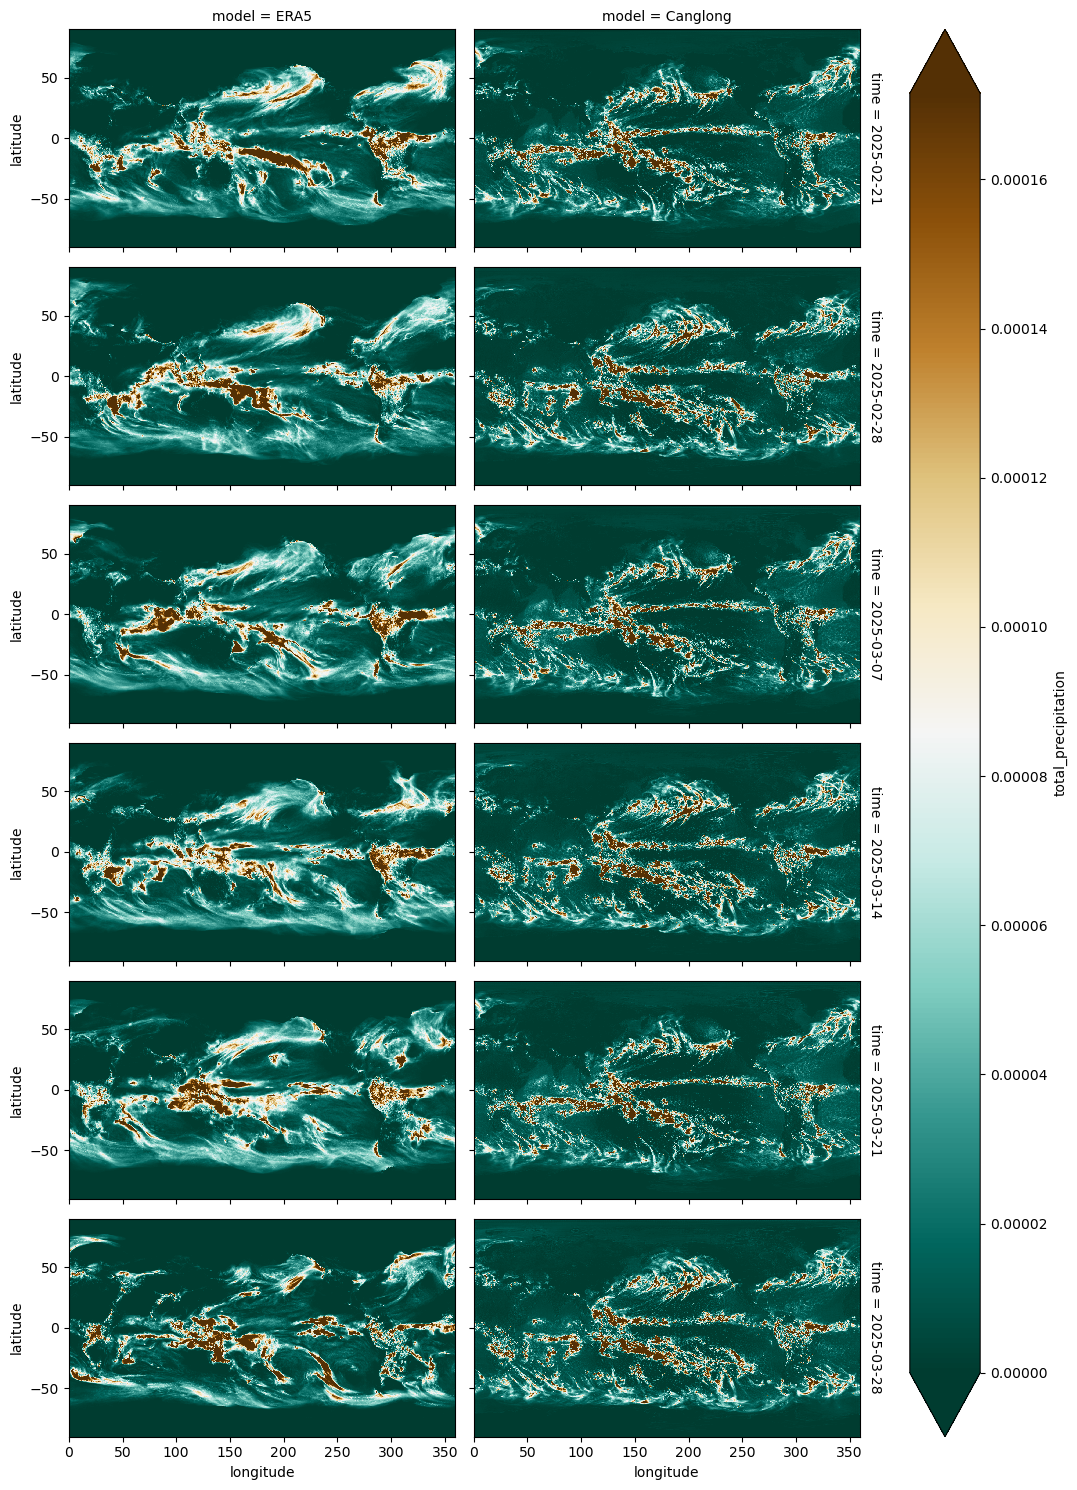

In [25]:
combined_ds.total_precipitation.plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2.5, vmin=0, cmap='BrBG_r'
)

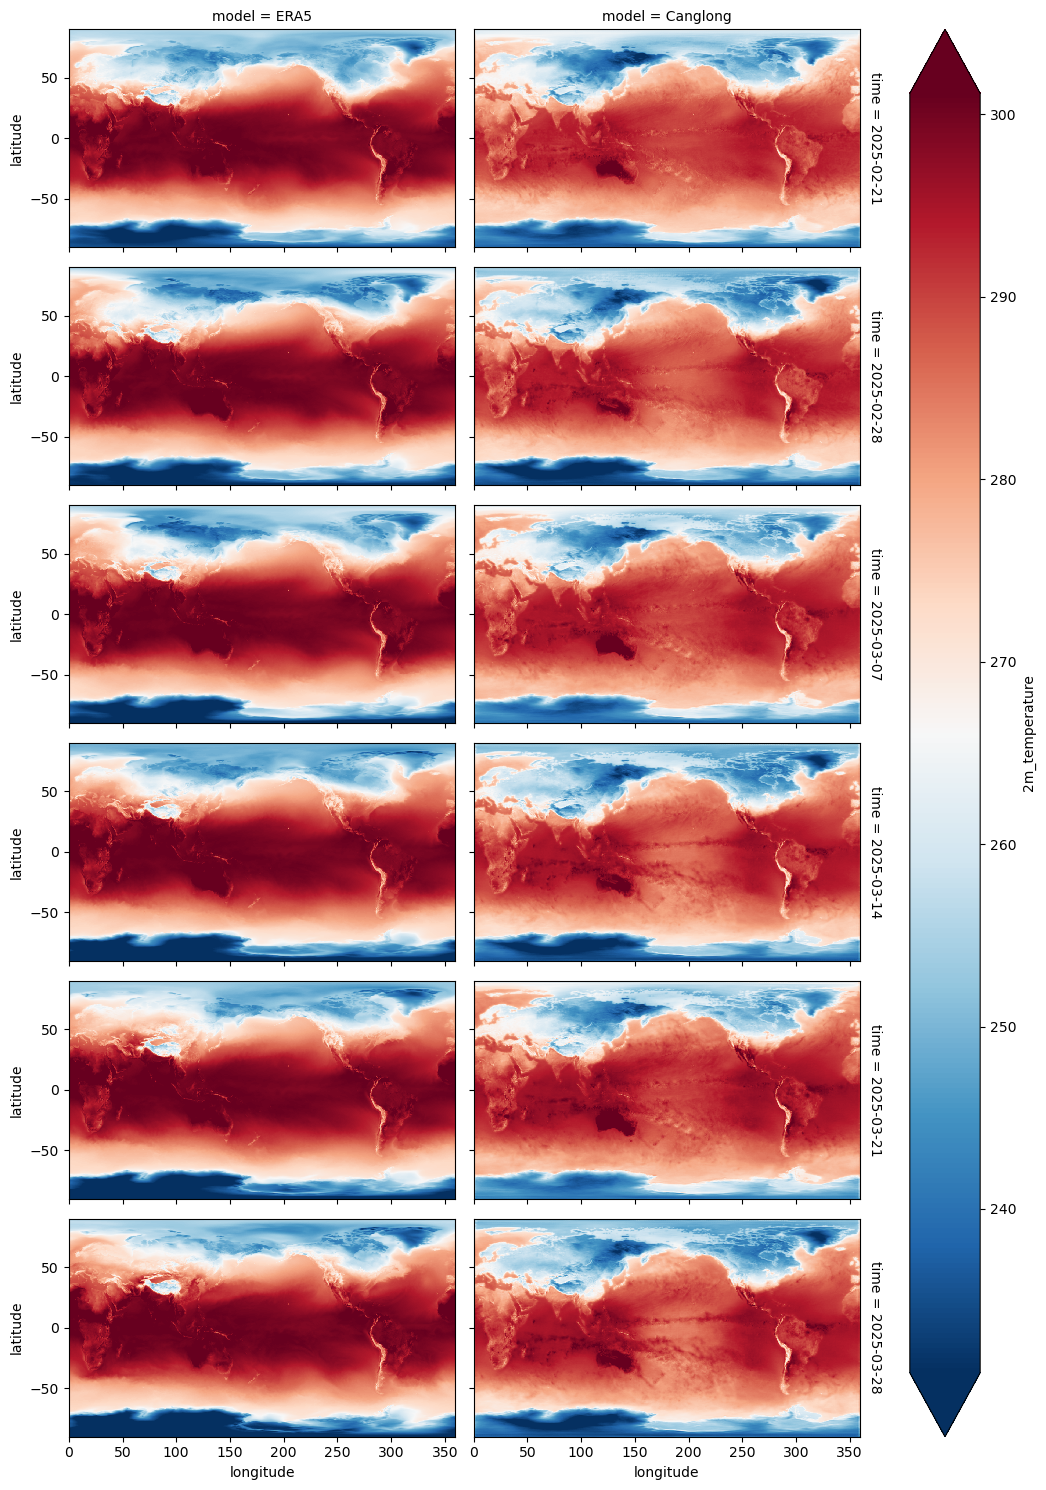

In [26]:
combined_ds['2m_temperature'].plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2.5, cmap='RdBu_r'
)